In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [ ]:
df_densite = pd.read_csv('../data/Densite.csv', sep=',', encoding='utf-8')
df_densite.head()

,dept_code,01-Médecine générale,02-Chirurgie,03-Ophtalmologie,04-Oto-rhino-laryngologie,05-Anesthésie-Réanimation,06-Biologie médicale,07-Cardiologie,08-Dermatologie,09-Gastro-entérologie,10-Gynécologie,11-Pédiatrie,12-Pneumologie,13-Psychiatrie et neuropsychiatrie,14-Plateaux techniques,15-Autre spécialité,Total général
0,1,"100,11","9,53","4,62","2,09","8,34","1,04","2,38","0,89","2,23","5,36","3,87","2,23","10,28","7,6","20,11","180,68"
1,2,"101,23","13,13","5,14","1,9","13,7","2,28","7,42","3,04","3,04","6,28","8,56","4,95","11,61","11,42","23,97","217,67"
2,3,"131,75","17,93","7,47","2,09","13,74","2,09","8,66","2,39","3,88","8,96","5,68","2,99","15,24","15,24","35,25","273,36"
3,4,"165,09","17,94","7,18","4,19","13,16","3,59","7,18","2,39","2,39","7,18","7,18","1,2","16,15","8,97","32,9","296,69"
4,5,"273,86","20,47","9,88","7,06","27,53","4,23","10,59","4,23","7,76","8,47","8,47","9,18","21,88","17,65","41,64","472,9"


In [10]:
df_effectif = pd.read_csv('../data/Effectifs.csv', sep=',', encoding='utf-8')
df_effectif.head()

,dept_code,01-Médecine générale,02-Chirurgie,03-Ophtalmologie,04-Oto-rhino-laryngologie,05-Anesthésie-Réanimation,06-Biologie médicale,07-Cardiologie,08-Dermatologie,09-Gastro-entérologie,10-Gynécologie,11-Pédiatrie,12-Pneumologie,13-Psychiatrie et neuropsychiatrie,14-Plateaux techniques,15-Autre spécialité,Total général
0,1,672,64,31,14,56,7,16,6,15,36,26,15,69,51,135,1213
1,2,532,69,27,10,72,12,39,16,16,33,45,26,61,60,126,1144
2,3,441,60,25,7,46,7,29,8,13,30,19,10,51,51,118,915
3,4,276,30,12,7,22,6,12,4,4,12,12,2,27,15,55,496
4,5,388,29,14,10,39,6,15,6,11,12,12,13,31,25,59,670


In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# df_densite et df_effectif existent déjà
# Vérifie au besoin:
# print(df_densite.columns)
# print(df_effectif.columns)

# 1. Colonnes de spécialités (toutes sauf dept_code et Total général)
specialite_cols = [
    col for col in df_densite.columns
    if col not in ["dept_code", "Total général"]
]

# 2. Densité en format long
densite_long = df_densite.melt(
    id_vars="dept_code",
    value_vars=specialite_cols,
    var_name="specialite",
    value_name="densite"
)

# 3. Effectif en format long
effectif_long = df_effectif.melt(
    id_vars="dept_code",
    value_vars=specialite_cols,
    var_name="specialite",
    value_name="effectif"
)

# 4. Fusion des deux
df_long = densite_long.merge(
    effectif_long,
    on=["dept_code", "specialite"],
    how="left"
)

# 5. Nettoyer les codes départements (01, 02, ..., 2A, 2B)
def clean_dept(code):
    s = str(code).strip()
    if s in ["2A", "2B"]:
        return s
    if s.isdigit():
        return s.zfill(2)   # 1 -> 01, 2 -> 02, etc.
    return s

df_long["dept_code_clean"] = df_long["dept_code"].apply(clean_dept)

# (optionnel) libellé propre de la spécialité
df_long["specialite_label"] = df_long["specialite"].str.replace(
    r"^\d{2}-", "", regex=True
)


In [17]:
# 6. Charger les contours des départements
gdf_dept = gpd.read_file("../data/departements.geojson")

print(gdf_dept.columns)  # pour vérifier les noms, souvent: 'code', 'nom', 'geometry'

Index(['code', 'nom', 'geometry'], dtype='object')


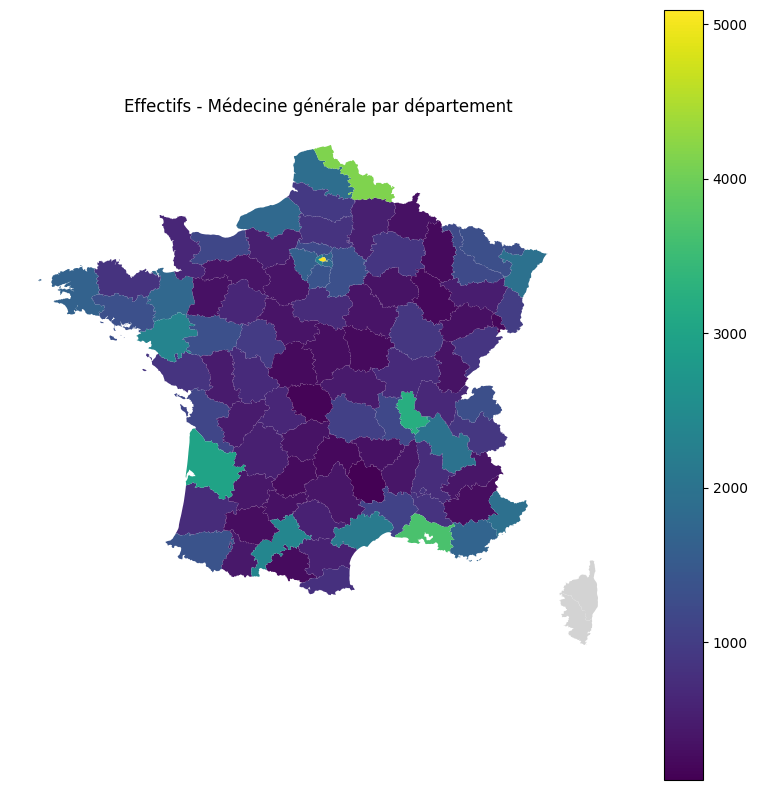

In [18]:
# Choisir la spécialité à cartographier
spec_code = "01-Médecine générale"   # version avec code
# ou si tu préfères par label :
# spec_label = "Médecine générale"
# df_spec = df_long[df_long["specialite_label"] == spec_label].copy()

df_spec = df_long[df_long["specialite"] == spec_code].copy()

# Fusion avec les contours des départements
gdf_merged = gdf_dept.merge(
    df_spec,
    left_on="code",           # colonne dans le GeoJSON
    right_on="dept_code_clean",
    how="left"
)

# 7. Tracer la carte (par effectif ou densité)
fig, ax = plt.subplots(figsize=(8, 8))

# Choisis la colonne à représenter : 'effectif' ou 'densite'
gdf_merged.plot(
    column="effectif",    # ou 'densite'
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "Pas de données"
    }
)

ax.set_title("Effectifs - Médecine générale par département")
ax.axis("off")
plt.tight_layout()
plt.show()


In [19]:
print(df_long["specialite"].unique())


['01-Médecine générale' '02-Chirurgie' '03-Ophtalmologie'
 '04-Oto-rhino-laryngologie' '05-Anesthésie-Réanimation'
 '06-Biologie médicale' '07-Cardiologie' '08-Dermatologie'
 '09-Gastro-entérologie' '10-Gynécologie' '11-Pédiatrie' '12-Pneumologie'
 '13-Psychiatrie et neuropsychiatrie' '14-Plateaux techniques'
 '15-Autre spécialité']


In [20]:
spec_code = "02-Chirurgie"